In [ ]:
import pandas as pd
import numpy as np
import re
import string
import joblib
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from flask import Flask, request, jsonify

In [ ]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Load dataset
df = pd.read_csv("Ulasan.csv")

def preprocess_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words("english")]
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    return " ".join(words)


- **Memuat Data:** Membaca file CSV "Ulasan.csv" dan menyimpannya dalam DataFrame `df` untuk analisis lebih lanjut.

- **Preprocessing Teks:**
  - **Lowercase:** Mengubah teks menjadi huruf kecil untuk konsistensi.
  - **Hapus Tanda Baca:** Menghilangkan semua karakter tanda baca menggunakan ekspresi reguler.
  - **Tokenisasi:** Memecah teks menjadi kata-kata.
  - **Hapus Stopwords:** Menghapus kata-kata umum bahasa Inggris yang tidak informatif.
  - **Stemming:** Mengubah kata-kata ke bentuk dasar menggunakan PorterStemmer.
  - **Rekonstruksi Teks:** Menggabungkan token yang sudah diproses kembali menjadi sebuah string.

In [ ]:
# Preprocess dataset
df = df.dropna(subset=['reviews.text', 'reviews.rating'])
df['sentiment'] = df['reviews.rating'].apply(lambda x: 'positive' if x > 3 else 'negative')
df['cleaned_review'] = df['reviews.text'].apply(preprocess_text)

- **Menghapus Data Kosong:**  
  `df.dropna(subset=['reviews.text', 'reviews.rating'])`  
  Menghapus baris yang memiliki nilai kosong pada kolom `reviews.text` atau `reviews.rating` agar data yang digunakan lengkap.

- **Membuat Label Sentimen:**  
  `df['sentiment'] = df['reviews.rating'].apply(lambda x: 'positive' if x > 3 else 'negative')`  
  Menambahkan kolom `sentiment` berdasarkan nilai `reviews.rating`. Rating di atas 3 diberi label "positive", sedangkan sebaliknya diberi label "negative".

- **Membersihkan Teks Ulasan:**  
  `df['cleaned_review'] = df['reviews.text'].apply(preprocess_text)`  
  Menerapkan fungsi `preprocess_text` pada setiap ulasan di kolom `reviews.text` untuk menghasilkan versi teks yang telah dibersihkan dan siap digunakan dalam analisis lebih lanjut.

In [ ]:
# Split dataset
X = df['cleaned_review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- **Definisi Variabel:**  
  - `X` diisi dengan data ulasan yang sudah dibersihkan (`cleaned_review`).  
  - `y` diisi dengan label sentimen (`sentiment`).

- **Pembagian Dataset:**  
  Fungsi `train_test_split` digunakan untuk membagi data menjadi:
  - **Data Pelatihan:** (`X_train`, `y_train`) untuk melatih model.
  - **Data Pengujian:** (`X_test`, `y_test`) untuk mengevaluasi performa model.
  
  Parameter `test_size=0.2` berarti 20% data digunakan untuk pengujian, dan `random_state=42` memastikan pembagian data yang konsisten dan dapat direproduksi.

In [ ]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

- **Inisialisasi Vectorizer:**  
  Membuat objek `TfidfVectorizer` untuk mengonversi teks menjadi fitur numerik berdasarkan bobot TF-IDF.

- **Transformasi Data Pelatihan:**  
  `fit_transform` pada `X_train` menghitung statistik TF-IDF dari data pelatihan dan langsung mentransformasikan teks menjadi matriks fitur.

- **Transformasi Data Pengujian:**  
  `transform` pada `X_test` menggunakan statistik yang telah dipelajari dari data pelatihan untuk mengubah teks pengujian menjadi matriks fitur, memastikan konsistensi representasi fitur.

In [ ]:
# Train models
models = {
    "Logistic Regression": LogisticRegression(),
    "Naïve Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier()
}

best_model = None
best_accuracy = 0

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model

Logistic Regression Accuracy: 0.8771
              precision    recall  f1-score   support

    negative       1.00      0.19      0.33        36
    positive       0.87      1.00      0.93       200

    accuracy                           0.88       236
   macro avg       0.94      0.60      0.63       236
weighted avg       0.89      0.88      0.84       236

Naïve Bayes Accuracy: 0.8729
              precision    recall  f1-score   support

    negative       1.00      0.17      0.29        36
    positive       0.87      1.00      0.93       200

    accuracy                           0.87       236
   macro avg       0.93      0.58      0.61       236
weighted avg       0.89      0.87      0.83       236

Random Forest Accuracy: 0.8941
              precision    recall  f1-score   support

    negative       0.82      0.39      0.53        36
    positive       0.90      0.98      0.94       200

    accuracy                           0.89       236
   macro avg       0.86      0.

- **Inisialisasi Model:**  
  Tiga model machine learning digunakan untuk klasifikasi sentimen:
  - **Logistic Regression**
  - **Multinomial Naïve Bayes**
  - **Random Forest Classifier**

- **Pelatihan Model & Evaluasi:**  
  - Melatih setiap model menggunakan `fit` dengan data **TF-IDF training**.
  - Melakukan prediksi (`predict`) pada data **TF-IDF testing**.
  - Menghitung **akurasi** menggunakan `accuracy_score`.
  - Menampilkan laporan klasifikasi (`classification_report`), termasuk precision, recall, dan F1-score.

- **Pemilihan Model Terbaik:**  
  - Model dengan **akurasi tertinggi** disimpan sebagai `best_model`.
  - **Best accuracy** diperbarui jika ditemukan model dengan performa lebih baik.

<ipython-input-8-8b0a81e04ef8>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


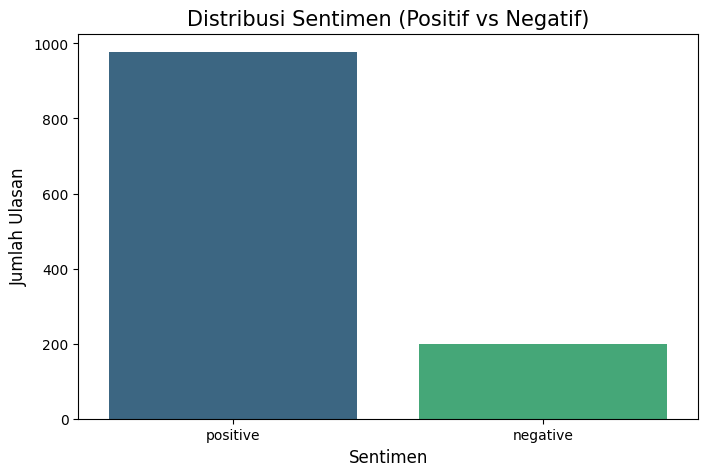

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisasi distribusi sentimen
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Distribusi Sentimen (Positif vs Negatif)', fontsize=15)
plt.xlabel('Sentimen', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)
plt.show()

- **Import Library:**  
  - `matplotlib.pyplot` dan `seaborn` digunakan untuk membuat visualisasi data.

- **Membuat Plot Distribusi Sentimen:**  
  - `sns.countplot` menampilkan jumlah ulasan berdasarkan kategori sentimen (`positive` vs `negative`).
  - **`palette='viridis'`** digunakan untuk pewarnaan yang menarik.
  - **`plt.title`**, **`plt.xlabel`**, dan **`plt.ylabel`** menambahkan informasi pada grafik.

- **Menampilkan Plot:**  
  - `plt.show()` digunakan untuk menampilkan hasil visualisasi.

Visualisasi ini membantu memahami distribusi sentimen dalam dataset sebelum melakukan analisis lebih lanjut.

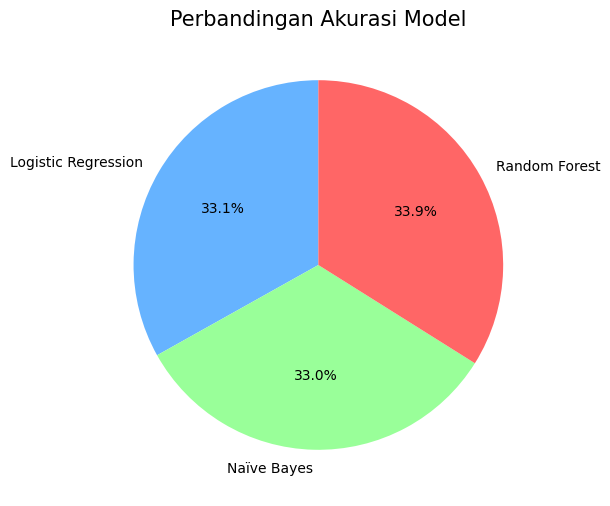

In [ ]:
# Akurasi per model
accuracy_dict = {
    "Logistic Regression": accuracy_score(y_test, LogisticRegression().fit(X_train_tfidf, y_train).predict(X_test_tfidf)),
    "Naïve Bayes": accuracy_score(y_test, MultinomialNB().fit(X_train_tfidf, y_train).predict(X_test_tfidf)),
    "Random Forest": accuracy_score(y_test, RandomForestClassifier().fit(X_train_tfidf, y_train).predict(X_test_tfidf))
}

# Plot perbandingan akurasi model menggunakan pie chart
plt.figure(figsize=(8, 6))
plt.pie(accuracy_dict.values(), labels=accuracy_dict.keys(), autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#99ff99', '#ff6666'])
plt.title('Perbandingan Akurasi Model', fontsize=15)
plt.show()

- **Menghitung Akurasi Model:**  
  - Melatih kembali setiap model (Logistic Regression, Naïve Bayes, dan Random Forest).
  - Menggunakan `accuracy_score` untuk menghitung akurasi prediksi terhadap data uji (`y_test`).
  - Hasil akurasi disimpan dalam `accuracy_dict`.

- **Visualisasi Akurasi Model:**  
  - **Pie Chart (`plt.pie`)** digunakan untuk membandingkan akurasi model.  
  - **`autopct='%1.1f%%'`** menampilkan persentase akurasi di dalam pie chart.  
  - **`startangle=90`** mengatur rotasi awal diagram agar lebih estetis.  
  - **Warna yang berbeda (`colors=['#66b3ff', '#99ff99', '#ff6666']`)** digunakan untuk membedakan setiap model.  
  - **Judul (`plt.title`)** ditambahkan untuk memberi konteks pada visualisasi.

Pie chart ini membantu dalam memahami model mana yang memiliki performa terbaik berdasarkan akurasi prediksi.

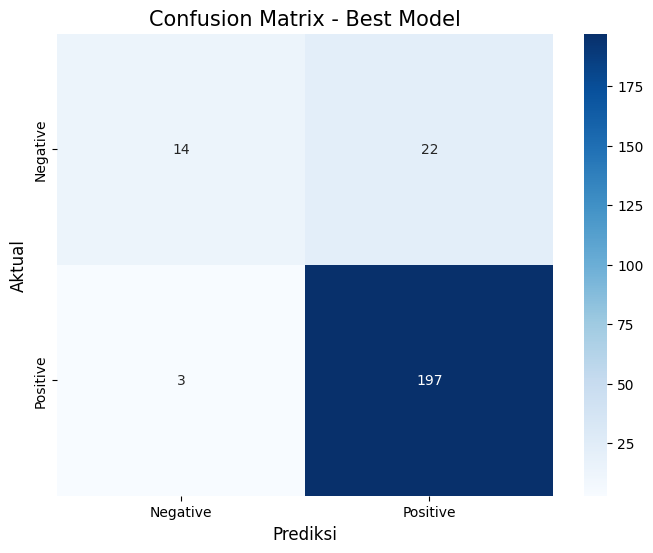

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix untuk model terbaik
y_pred_best_model = best_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred_best_model)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Best Model', fontsize=15)
plt.xlabel('Prediksi', fontsize=12)
plt.ylabel('Aktual', fontsize=12)
plt.show()

- **Menghitung Confusion Matrix:**  
  - `best_model.predict(X_test_tfidf)`: Menggunakan model terbaik untuk memprediksi data uji.
  - `confusion_matrix(y_test, y_pred_best_model)`: Membandingkan hasil prediksi dengan label aktual untuk mendapatkan matriks kebingungan.

- **Visualisasi Confusion Matrix:**  
  - `sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')`:  
    - Menampilkan matriks sebagai heatmap dengan nilai numerik (`annot=True`).
    - Menggunakan format angka bulat (`fmt='d'`).
    - Pewarnaan biru (`cmap='Blues'`) untuk estetika.
  - **Label Sumbu:**  
    - `xticklabels=['Negative', 'Positive']` dan `yticklabels=['Negative', 'Positive']` memberikan label yang lebih mudah dibaca.
    - `plt.xlabel('Prediksi')` dan `plt.ylabel('Aktual')` menunjukkan arah perbandingan.

Confusion matrix ini membantu dalam mengevaluasi kinerja model dengan menunjukkan jumlah prediksi yang benar dan salah untuk masing-masing kelas.

<ipython-input-12-e7519dd7d943>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracy_dict.values()), y=list(accuracy_dict.keys()), ax=axes[0], palette='coolwarm')
<ipython-input-12-e7519dd7d943>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(precision_dict.values()), y=list(precision_dict.keys()), ax=axes[1], palette='Blues')
<ipython-input-12-e7519dd7d943>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(recall_dict.values()), y=list(recall_dict.keys()), ax=axes[2], palette='Greens')
<ipython-input-12-e7519dd7

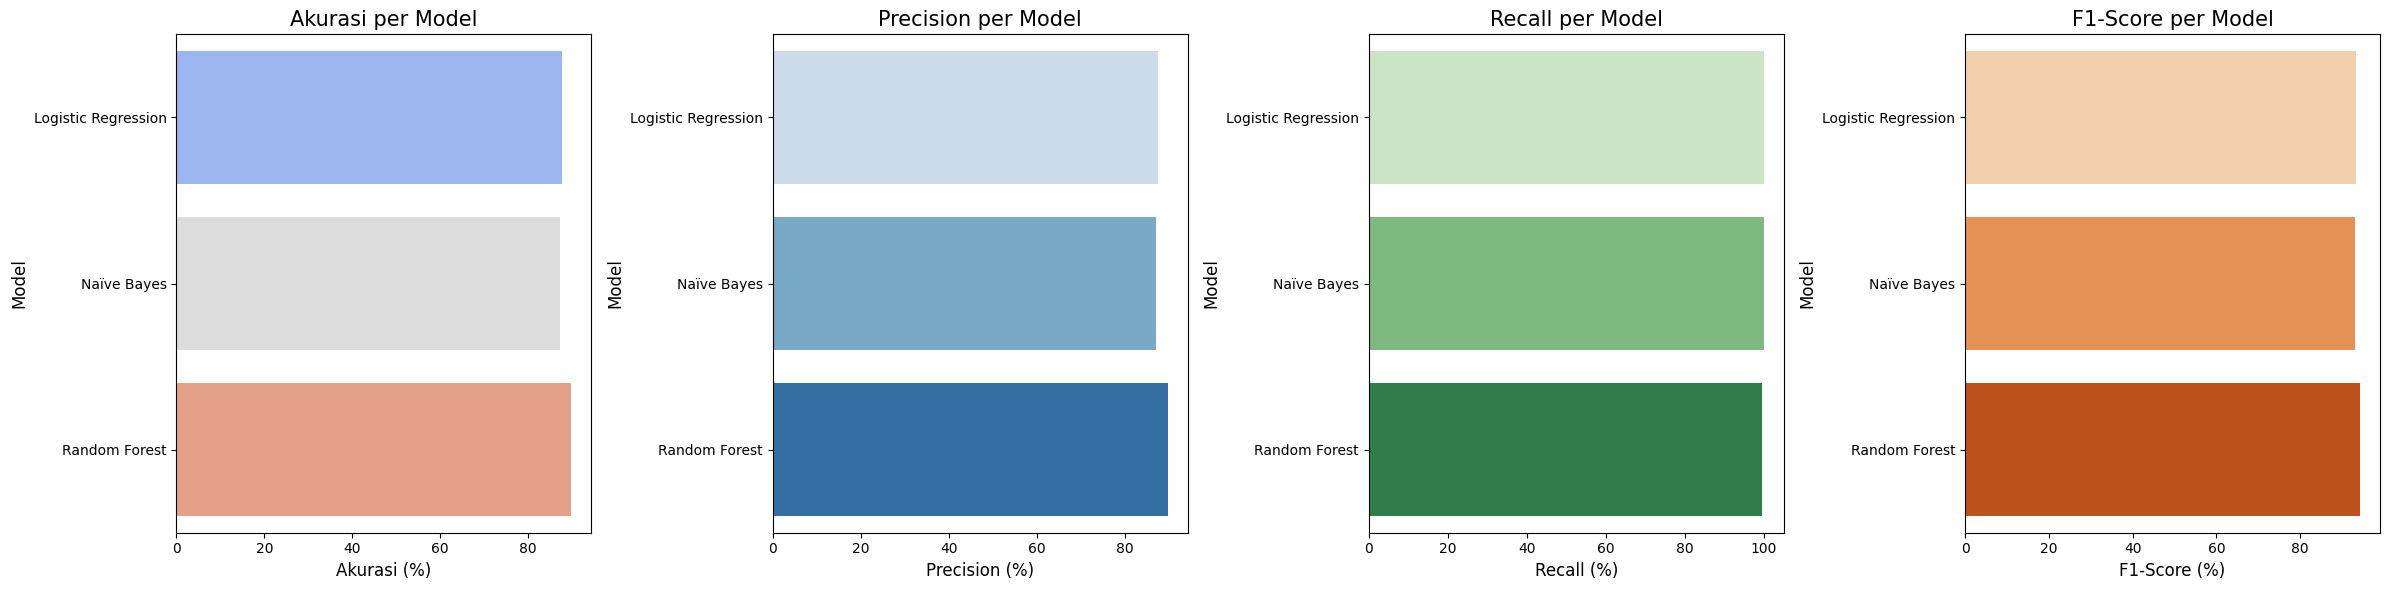

Tabel Perbandingan Metrik Evaluasi Model:
                     Akurasi (%)  Precision (%)  Recall (%)  F1-Score (%)
Logistic Regression    87.711864      87.336245       100.0     93.240093
Naïve Bayes            87.288136      86.956522       100.0     93.023256
Random Forest          89.830508      89.639640        99.5     94.312796


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score # Import precision_score, recall_score, and f1_score

# Menghitung Precision, Recall, F1-Score, dan Akurasi per model dalam persen
accuracy_dict = {}
precision_dict = {}
recall_dict = {}
f1_dict = {}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, pos_label='positive') * 100
    recall = recall_score(y_test, y_pred, pos_label='positive') * 100
    f1 = f1_score(y_test, y_pred, pos_label='positive') * 100

    accuracy_dict[name] = accuracy
    precision_dict[name] = precision
    recall_dict[name] = recall
    f1_dict[name] = f1

# Membuat plot secara horizontal (sejajar)
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Plot Accuracy
sns.barplot(x=list(accuracy_dict.values()), y=list(accuracy_dict.keys()), ax=axes[0], palette='coolwarm')
axes[0].set_title('Akurasi per Model', fontsize=15)
axes[0].set_xlabel('Akurasi (%)', fontsize=12)
axes[0].set_ylabel('Model', fontsize=12)

# Plot Precision
sns.barplot(x=list(precision_dict.values()), y=list(precision_dict.keys()), ax=axes[1], palette='Blues')
axes[1].set_title('Precision per Model', fontsize=15)
axes[1].set_xlabel('Precision (%)', fontsize=12)
axes[1].set_ylabel('Model', fontsize=12)

# Plot Recall
sns.barplot(x=list(recall_dict.values()), y=list(recall_dict.keys()), ax=axes[2], palette='Greens')
axes[2].set_title('Recall per Model', fontsize=15)
axes[2].set_xlabel('Recall (%)', fontsize=12)
axes[2].set_ylabel('Model', fontsize=12)

# Plot F1-Score
sns.barplot(x=list(f1_dict.values()), y=list(f1_dict.keys()), ax=axes[3], palette='Oranges')
axes[3].set_title('F1-Score per Model', fontsize=15)
axes[3].set_xlabel('F1-Score (%)', fontsize=12)
axes[3].set_ylabel('Model', fontsize=12)

# Menampilkan plot
plt.tight_layout()
plt.show()

# Tabel persen metrik evaluasi dengan Akurasi
metrics_df = pd.DataFrame({
    "Akurasi (%)": list(accuracy_dict.values()),
    "Precision (%)": list(precision_dict.values()),
    "Recall (%)": list(recall_dict.values()),
    "F1-Score (%)": list(f1_dict.values())
}, index=list(models.keys()))

print("Tabel Perbandingan Metrik Evaluasi Model:")
print(metrics_df)

- **Menghitung Metrik Evaluasi:**  
  - Menggunakan **accuracy, precision, recall, dan F1-score** untuk mengevaluasi model.
  - Hasil metrik dikalikan **100** agar ditampilkan dalam persentase.
  - **`pos_label='positive'`** digunakan agar metrik dihitung untuk kelas "positive".

- **Membandingkan Metrik dalam Grafik:**  
  - **Empat subplot horizontal** dibuat untuk **Akurasi, Precision, Recall, dan F1-Score**.
  - Setiap grafik menampilkan model yang dibandingkan menggunakan **barplot** dari `seaborn`.
  - Warna palet berbeda (`coolwarm`, `Blues`, `Greens`, `Oranges`) digunakan untuk membedakan metrik.

- **Menampilkan Tabel Evaluasi:**  
  - Tabel `metrics_df` menyajikan hasil evaluasi dalam format yang mudah dibaca.
  - Dicetak sebagai ringkasan numerik untuk perbandingan cepat.

Dengan visualisasi ini, kita dapat **memilih model terbaik** berdasarkan metrik yang paling sesuai dengan kebutuhan analisis.

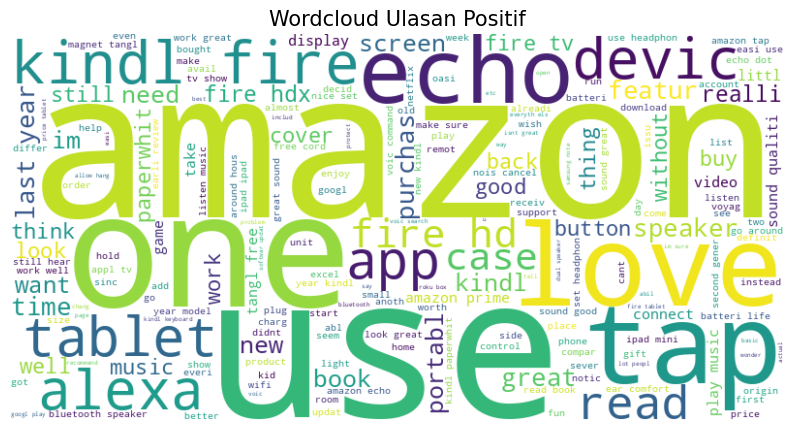

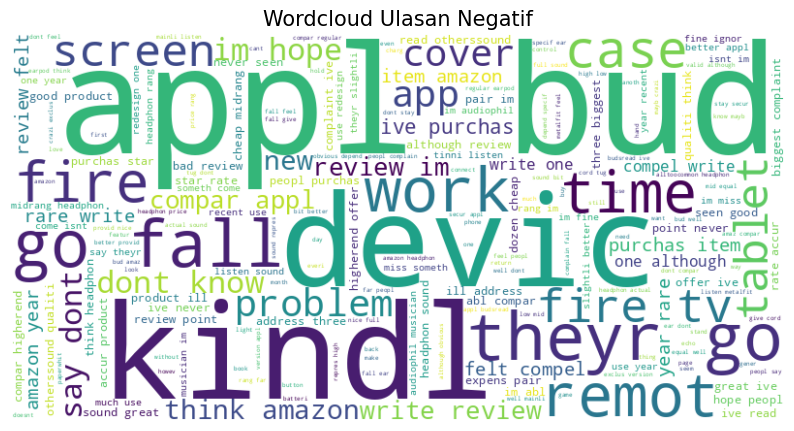

In [ ]:
from wordcloud import WordCloud

# Gabungkan teks positif dan negatif
positive_reviews = " ".join(df[df['sentiment'] == 'positive']['cleaned_review'])
negative_reviews = " ".join(df[df['sentiment'] == 'negative']['cleaned_review'])

# Generate wordcloud untuk ulasan positif
plt.figure(figsize=(10, 6))
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Wordcloud Ulasan Positif', fontsize=15)
plt.axis('off')
plt.show()

# Generate wordcloud untuk ulasan negatif
plt.figure(figsize=(10, 6))
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Wordcloud Ulasan Negatif', fontsize=15)
plt.axis('off')
plt.show()

### **Penjelasan Kode: WordCloud untuk Analisis Sentimen Ulasan Produk**
Kode ini digunakan untuk **menganalisis kata-kata yang paling sering muncul** dalam ulasan positif dan negatif dengan **WordCloud**, yang memberikan representasi visual berbasis frekuensi kata.

---

### **1. Menggabungkan Teks Ulasan**

- **`df[df['sentiment'] == 'positive']`** → Memfilter hanya ulasan dengan sentimen positif.
- **`df['cleaned_review']`** → Menggunakan teks ulasan yang telah diproses.
- **`" ".join(...)`** → Menggabungkan seluruh ulasan menjadi satu string besar.

---

### **2. Membuat WordCloud untuk Ulasan Positif**
- **`WordCloud(...).generate(positive_reviews)`** → Membuat WordCloud berdasarkan kata-kata dalam ulasan positif.
- **`background_color='white'`** → Menjadikan latar belakang putih agar lebih jelas.
- **`plt.imshow(wordcloud_pos, interpolation='bilinear')`** → Menampilkan WordCloud.
- **`plt.axis('off')`** → Menghilangkan sumbu agar lebih bersih.
- **`plt.title(...)`** → Menambahkan judul untuk membedakan visualisasi.

---

### **3. Membuat WordCloud untuk Ulasan Negatif**

- **Langkah-langkahnya sama dengan WordCloud untuk ulasan positif**, tetapi menggunakan **negative_reviews**.

---

### **4. Fungsi WordCloud dalam Analisis Sentimen**
- **Mengidentifikasi Kata-Kata Dominan**  
  - Kata yang lebih sering muncul akan tampil lebih besar.
  - Bisa membantu memahami **aspek positif dan negatif** yang sering disebut dalam ulasan.

- **Membantu Pemasaran & Peningkatan Produk**  
  - Kata-kata dominan dalam **ulasan positif** bisa menjadi **USP (Unique Selling Points)**.
  - Kata-kata dominan dalam **ulasan negatif** bisa menjadi **masukan untuk perbaikan produk**.

- **Visualisasi yang Mudah Dipahami**  
  - WordCloud memungkinkan **interpretasi cepat** tanpa perlu membaca seluruh dataset.

---


In [ ]:
# Save best model and vectorizer
joblib.dump(best_model, "best_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

- `joblib.dump(best_model, "best_model.pkl")`: Menyimpan model yang sudah dilatih, yaitu `best_model` (misalnya model machine learning seperti Logistic Regression, Random Forest, dll.) ke dalam file dengan nama `best_model.pkl`.
- `joblib.dump(tfidf, "tfidf_vectorizer.pkl")`: Menyimpan vektorisasi TF-IDF (digunakan untuk mengubah data teks menjadi bentuk numerik) ke dalam file dengan nama `tfidf_vectorizer.pkl`.

In [ ]:
# Flask API
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    review = data.get("review", "")

    if not review:
        return jsonify({"error": "Input tidak valid. Harap masukkan teks ulasan."}), 400

    processed_review = preprocess_text(review)
    transformed_review = tfidf.transform([processed_review])
    prediction = best_model.predict(transformed_review)[0]

    return jsonify({"review": review, "sentiment": prediction})

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


- `app = Flask(__name__)`: Membuat aplikasi Flask baru.
  
- `@app.route('/predict', methods=['POST'])`: Mendefinisikan endpoint `/predict` yang menerima request dengan metode POST. Endpoint ini akan digunakan untuk menerima data dari pengguna.

- `def predict():`: Fungsi `predict` yang dipanggil ketika ada permintaan POST ke endpoint `/predict`.

- `data = request.get_json()`: Mengambil data dalam format JSON yang dikirimkan dalam request.

- `review = data.get("review", "")`: Mengambil teks ulasan yang dikirimkan oleh pengguna dari JSON. Jika tidak ada ulasan, akan diambil string kosong.

- `if not review:`: Mengecek apakah teks ulasan kosong. Jika kosong, akan mengembalikan pesan kesalahan dengan status 400.

- `processed_review = preprocess_text(review)`: Memproses teks ulasan menggunakan fungsi `preprocess_text` yang mungkin Anda buat sebelumnya untuk membersihkan dan menyiapkan teks.

- `transformed_review = tfidf.transform([processed_review])`: Mengubah teks yang sudah diproses ke dalam bentuk numerik menggunakan vectorizer TF-IDF.

- `prediction = best_model.predict(transformed_review)[0]`: Menggunakan model terbaik (`best_model`) untuk memprediksi sentimen dari ulasan yang sudah diubah menjadi representasi numerik.

- `return jsonify({"review": review, "sentiment": prediction})`: Mengembalikan hasil prediksi dalam format JSON yang berisi ulasan dan hasil prediksi sentimen.

- `if __name__ == '__main__': app.run(debug=True)`: Menjalankan aplikasi Flask dengan mode debug yang memungkinkan Anda melihat log error saat pengembangan.

Dengan API ini, Anda dapat mengirimkan ulasan dalam format JSON menggunakan permintaan POST ke `/predict` dan menerima hasil sentimen dalam format JSON.